🏏 CRICKET TEAM SCORE DISTRIBUTION ANALYSIS - EXPANDED RANGE

📊 Running 1 simulation sets...
   • 10,000 cards per set
   • 10,000 total cards
⏳ This may take 5-10 minutes. Please wait...

🔍 DATA QUALITY CHECK:
   Total players in dataset: 3228

   Player distribution:
   - Bowler: 1747
   - Batsman: 1251
   - Wicketkeeper: 230

✅ Using 3228 total players


🔄 Simulation Set 1/1
------------------------------------------------------------
   Progress: 2,000/10,000 cards generated...
   Progress: 4,000/10,000 cards generated...
   Progress: 6,000/10,000 cards generated...
   Progress: 8,000/10,000 cards generated...
   Progress: 10,000/10,000 cards generated...
   ✅ Set 1 complete: 10,000 teams generated

✅ ALL SIMULATIONS COMPLETE!
   Total teams generated: 10,000

📊 STATISTICAL SUMMARY - TEAM TOTAL SCORES (0-1000)
Highest Team Score:    979.46
Lowest Team Score:     296.59
Average Team Score:    563.19
Median (50th %ile):    551.75
Std Deviation:         113.92
Range:                 68

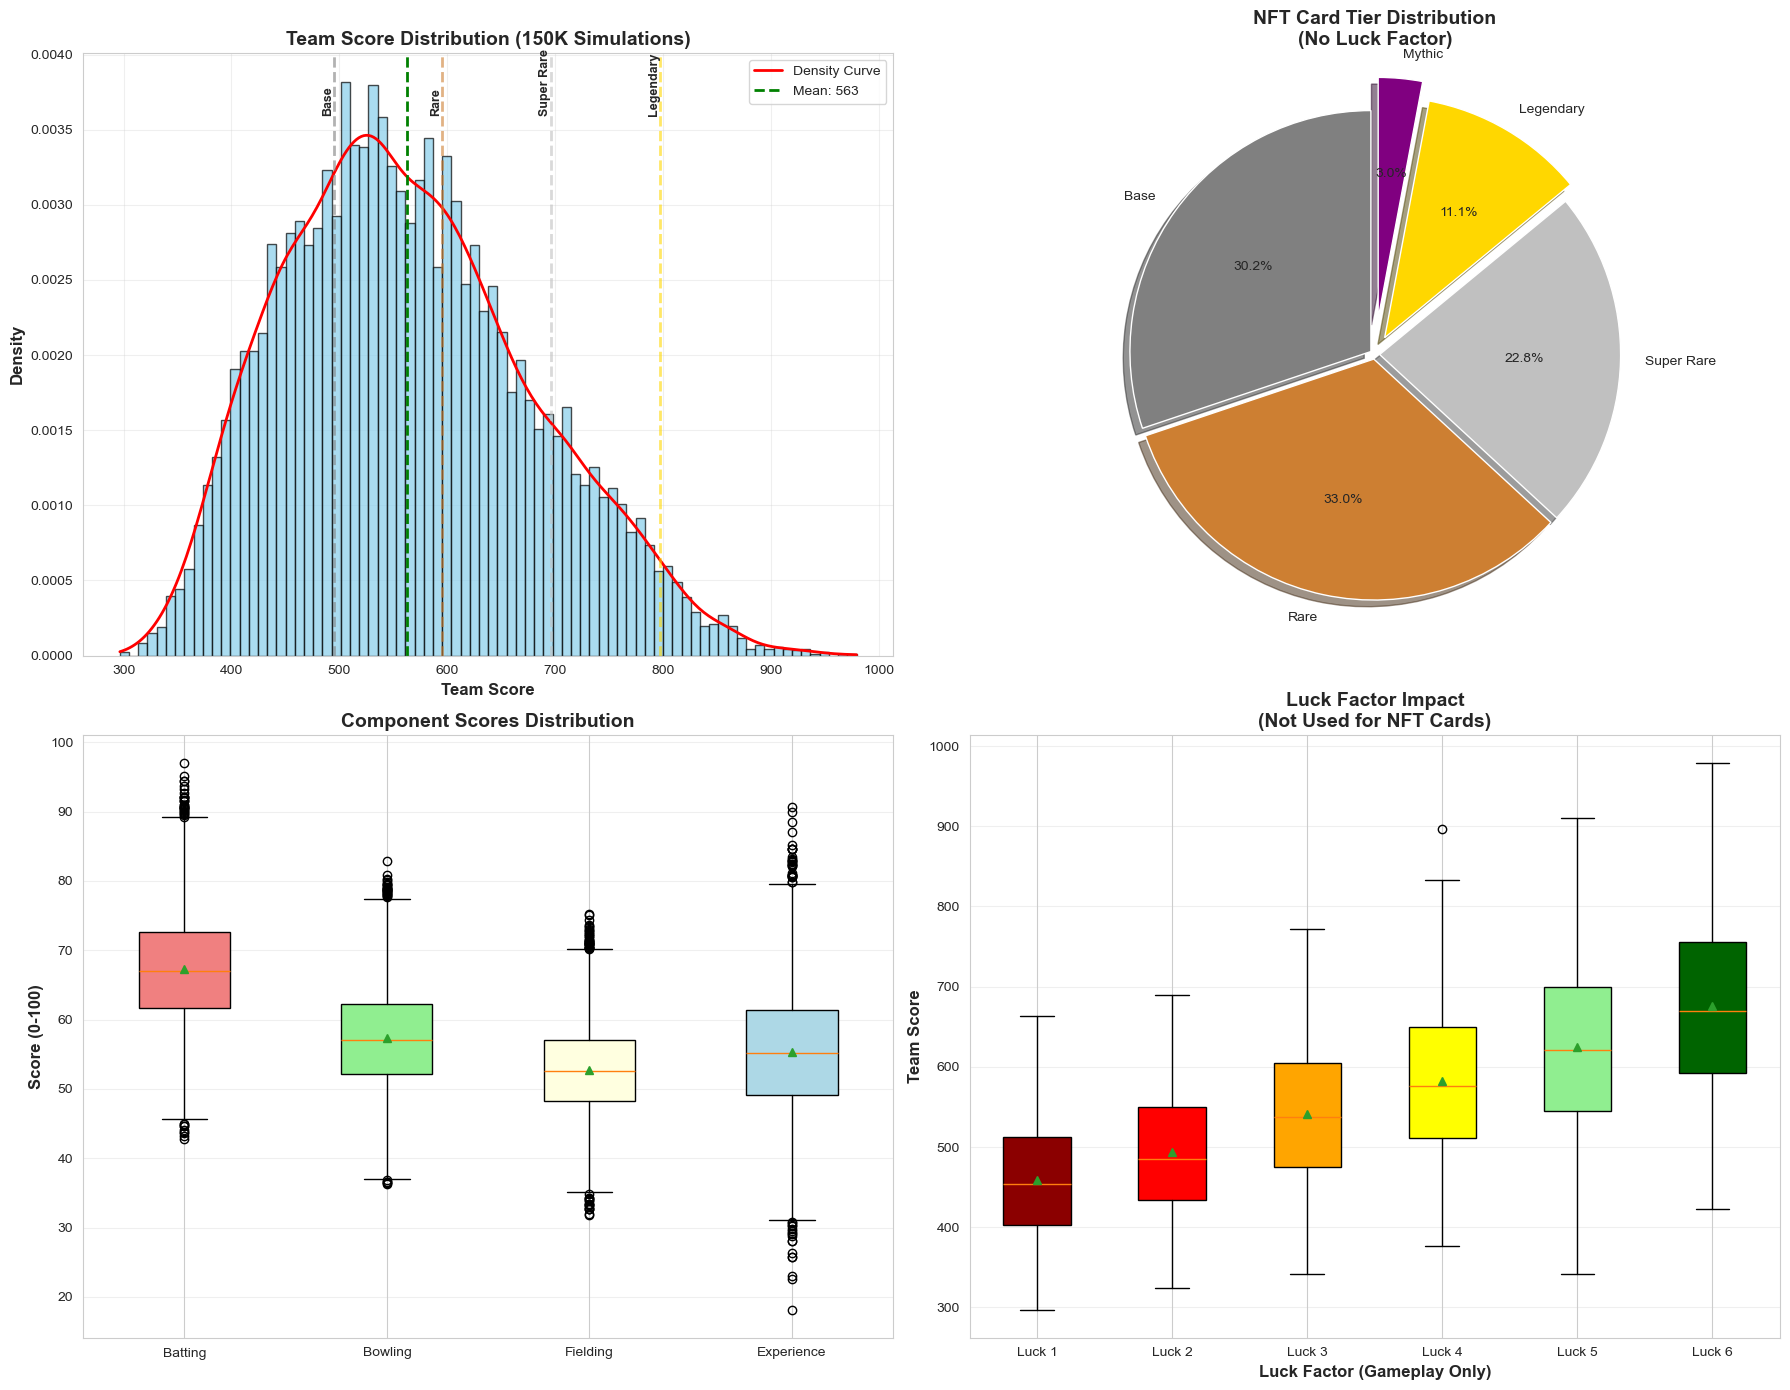


✅ SIMULATION ANALYSIS COMPLETE!

📊 Key Statistics:
   • Total simulations: 10,000
   • Simulation sets: 1
   • Score range: 296.59 - 979.46
   • Average score: 563.19
   • Std deviation: 113.92
   • Most common tier: Rare
   • Rarest tier: Mythic

🎴 NFT Card System:
   • Luck factor: NOT used for cards (gameplay only)
   • Card color: Based ONLY on team score
   • Tier distribution: See analysis above

📁 Output files generated:
   1. nft_expanded_distribution_analysis.png - Distribution charts

💡 Key Findings:
   ✅ Max score above 900 - excellent range coverage!
   • Cards scoring 800+: 271 (2.71%)
   • Cards scoring 900+: 22 (0.22%)

💡 Recommendations:
   1. Review tier balance vs target (40/25/20/10/5)
   2. Use suggested percentile ranges if distribution is off
   3. Adjust variance parameters if score range needs tweaking
   4. Remember: Luck factor for gameplay, NOT for card tiers

🏏 Thank you for using the Cricket Team Score Analyzer!


In [1]:
import pandas as pd
import numpy as np
import random
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

# =====================================================
# CONFIGURATION
# =====================================================
DATA_FILE = "Final_Player_Stats.csv"
TEAM_SIZE = {'Batsman': 6, 'Wicketkeeper': 1, 'Bowler': 4}

# Multiple simulation sets for stable distribution
NUM_SIMULATION_SETS = 1  # Run 1 set
CARDS_PER_SET = 10000     # 10K cards per set
TOTAL_SIMULATIONS = NUM_SIMULATION_SETS * CARDS_PER_SET  # 150K total

LONGEVITY_CONSTANTS = {
    'batting_k': 20,
    'league_batting_avg': 30.0,
    'bowling_k': 25,
    'league_bowling_avg': 35.0,
    'duck_k': 30
}

# INCREASED VARIANCE for wider score distribution
COMPONENT_VARIANCE = 0.12  # 12% (was 5%)
TEAM_VARIANCE = 0.08       # 8% (was 2%)

# =====================================================
# NFT CARD TIER SYSTEM (NO LUCK FACTOR)
# Card color determined ONLY by team score
# =====================================================
CARD_TIERS = {
    'Base': {'range': (0, 495), 'color': 'Black', 'rarity': 'Common'},
    'Rare': {'range': (495.001, 595), 'color': 'Bronze', 'rarity': 'Rare'},
    'Super Rare': {'range': (595.001, 696), 'color': 'Silver', 'rarity': 'Super Rare'},
    'Legendary': {'range': (696.001, 797), 'color': 'Gold', 'rarity': 'Legendary'},
    'Mythic': {'range': (797.001, 1000), 'color': 'Platinum', 'rarity': 'Mythic'}
}

# Target distribution (per team feedback)
IDEAL_DISTRIBUTION = {
    'Base': 40,       # 40%
    'Rare': 25,       # 25%
    'Super Rare': 20, # 20%
    'Legendary': 10,  # 10%
    'Mythic': 5       # 5%
}

def get_card_tier(score):
    """Determine card tier based ONLY on team score (no luck factor)"""
    for tier, info in CARD_TIERS.items():
        if info['range'][0] <= score <= info['range'][1]:
            return tier, info['color']
    return 'Mythic', 'Platinum'

print("="*80)
print("🏏 CRICKET TEAM SCORE DISTRIBUTION ANALYSIS - EXPANDED RANGE")
print("="*80)
print(f"\n📊 Running {NUM_SIMULATION_SETS} simulation sets...")
print(f"   • {CARDS_PER_SET:,} cards per set")
print(f"   • {TOTAL_SIMULATIONS:,} total cards")
print("⏳ This may take 5-10 minutes. Please wait...\n")

# =====================================================
# LOAD AND VALIDATE DATA
# =====================================================
players_df = pd.read_csv(DATA_FILE)

print("🔍 DATA QUALITY CHECK:")
print(f"   Total players in dataset: {len(players_df)}")

category_counts = players_df['Player_Category'].value_counts()
print(f"\n   Player distribution:")
for cat, count in category_counts.items():
    print(f"   - {cat}: {count}")

if 'Player_ID' not in players_df.columns:
    players_df['Player_ID'] = players_df.index

players_df['Total_Fielding'] = players_df['Stumpings_Total'] + players_df['Fielding_Catches']
print(f"\n✅ Using {len(players_df)} total players\n")

# =====================================================
# SCORING FUNCTIONS (SAME AS BEFORE)
# =====================================================

def percentile_score(value, all_values, min_score=0, max_score=100, lower_is_better=False):
    if pd.isna(value) or value < 0:
        return min_score
    valid_values = all_values[all_values.notna() & (all_values >= 0)]
    if len(valid_values) == 0:
        return min_score
    percentile = stats.percentileofscore(valid_values, value, kind='rank')
    if lower_is_better:
        percentile = 100 - percentile
    score = min_score + (percentile / 100) * (max_score - min_score)
    return np.clip(score, min_score, max_score)

def calculate_consistency_modifier(player_row):
    if player_row['Matches_Played'] < 5:
        return 1.0
    modifier = 1.0
    not_out_ratio = player_row['Not_Outs'] / max(player_row['Matches_Played'], 1)
    modifier += not_out_ratio * 0.08
    raw_duck_rate = player_row['Ducks_Career'] / max(player_row['Matches_Played'], 1)
    k = LONGEVITY_CONSTANTS['duck_k']
    typical_duck_rate = 0.15
    longevity_weight = player_row['Matches_Played'] / (player_row['Matches_Played'] + k)
    adjusted_duck_rate = (longevity_weight * raw_duck_rate + (1 - longevity_weight) * typical_duck_rate)
    duck_penalty = adjusted_duck_rate * 0.40
    modifier -= duck_penalty
    return np.clip(modifier, 0.85, 1.15)

def random_scale(score, max_variance=0.05):
    return score * random.uniform(1 - max_variance, 1 + max_variance)

def calculate_individual_batting_score(player_row, all_players_df):
    k = LONGEVITY_CONSTANTS['batting_k']
    league_avg = LONGEVITY_CONSTANTS['league_batting_avg']
    longevity_weight = player_row['Matches_Played'] / (player_row['Matches_Played'] + k)
    adjusted_batting_avg = (longevity_weight * player_row['Batting_Average'] + 
                            (1 - longevity_weight) * league_avg)
    avg_score = percentile_score(adjusted_batting_avg, all_players_df['Batting_Average'], 0, 100)
    runs_score = percentile_score(player_row['Total_Runs'], all_players_df['Total_Runs'], 0, 100)
    centuries_score = percentile_score(player_row['Centuries'], all_players_df['Centuries'], 0, 100)
    fifties_score = percentile_score(player_row['Fifties'], all_players_df['Fifties'], 0, 100)
    consistency = calculate_consistency_modifier(player_row)
    batting_score = (avg_score * 0.35 + runs_score * 0.25 + 
                     centuries_score * 0.20 + fifties_score * 0.20) * consistency
    return np.clip(batting_score, 0, 100)

def calculate_individual_bowling_score(player_row, all_players_df):
    k = LONGEVITY_CONSTANTS['bowling_k']
    league_avg = LONGEVITY_CONSTANTS['league_bowling_avg']
    longevity_weight = player_row['Matches_Played'] / (player_row['Matches_Played'] + k)
    adjusted_bowling_avg = (longevity_weight * player_row['Bowling_Average'] + 
                            (1 - longevity_weight) * league_avg)
    avg_score = percentile_score(adjusted_bowling_avg, all_players_df['Bowling_Average'], 
                                  0, 100, lower_is_better=True)
    wickets_score = percentile_score(player_row['Wickets_Total'], all_players_df['Wickets_Total'], 0, 100)
    five_wickets_score = percentile_score(player_row['Five_Wickets'], all_players_df['Five_Wickets'], 0, 100)
    matches_score = percentile_score(player_row['Matches_Played'], all_players_df['Matches_Played'], 0, 100)
    bowling_score = (avg_score * 0.35 + wickets_score * 0.30 + 
                     five_wickets_score * 0.20 + matches_score * 0.15)
    return np.clip(bowling_score, 0, 100)

def calculate_individual_fielding_score(player_row, all_players_df):
    catches_score = percentile_score(player_row['Fielding_Catches'], 
                                     all_players_df['Fielding_Catches'], 0, 100)
    stumpings_score = percentile_score(player_row['Stumpings_Total'], 
                                       all_players_df['Stumpings_Total'], 0, 100)
    if player_row['Player_Category'] == 'Wicketkeeper':
        stumpings_score = np.clip(stumpings_score * 1.2, 0, 100)
    fielding_score = catches_score * 0.65 + stumpings_score * 0.35
    return np.clip(fielding_score, 0, 100)

def calculate_individual_experience_score(player_row, all_players_df):
    matches_score = percentile_score(player_row['Matches_Played'], 
                                     all_players_df['Matches_Played'], 0, 100)
    return np.clip(matches_score, 0, 100)

# =====================================================
# TEAM GENERATION AND SCORING (INCREASED VARIANCE)
# =====================================================

def generate_team_score():
    """Generate one team and return its score and metadata"""
    batsmen_pool = players_df[players_df['Player_Category'] == 'Batsman']
    keepers_pool = players_df[players_df['Player_Category'] == 'Wicketkeeper']
    bowlers_pool = players_df[players_df['Player_Category'] == 'Bowler']
    
    if len(batsmen_pool) < TEAM_SIZE['Batsman'] or \
       len(keepers_pool) < TEAM_SIZE['Wicketkeeper'] or \
       len(bowlers_pool) < TEAM_SIZE['Bowler']:
        return None
    
    team_batsmen = batsmen_pool.sample(TEAM_SIZE['Batsman'], random_state=random.randint(1, 99999))
    team_keeper = keepers_pool.sample(TEAM_SIZE['Wicketkeeper'], random_state=random.randint(1, 99999))
    team_bowlers = bowlers_pool.sample(TEAM_SIZE['Bowler'], random_state=random.randint(1, 99999))
    
    team_df = pd.concat([team_batsmen, team_keeper, team_bowlers]).reset_index(drop=True)
    
    # Calculate individual scores
    team_df['Individual_Batting_Score'] = team_df.apply(
        lambda row: calculate_individual_batting_score(row, players_df), axis=1
    )
    team_df['Individual_Bowling_Score'] = team_df.apply(
        lambda row: calculate_individual_bowling_score(row, players_df), axis=1
    )
    team_df['Individual_Fielding_Score'] = team_df.apply(
        lambda row: calculate_individual_fielding_score(row, players_df), axis=1
    )
    team_df['Individual_Experience_Score'] = team_df.apply(
        lambda row: calculate_individual_experience_score(row, players_df), axis=1
    )
    
    team_df['Individual_Total_Score'] = (
        team_df['Individual_Batting_Score'] * 0.35 +
        team_df['Individual_Bowling_Score'] * 0.35 +
        team_df['Individual_Fielding_Score'] * 0.15 +
        team_df['Individual_Experience_Score'] * 0.15
    )
    
    # Team component scores with INCREASED VARIANCE
    batting_contributors = team_df[team_df['Player_Category'].isin(['Batsman', 'Wicketkeeper'])].nlargest(7, 'Individual_Batting_Score')
    weights_batting = [1.25, 1.20, 1.15, 1.10, 1.05, 1.0, 1.0][:len(batting_contributors)]
    team_batting_score = np.average(batting_contributors['Individual_Batting_Score'].values, weights=weights_batting)
    team_batting_score = random_scale(team_batting_score, COMPONENT_VARIANCE)
    team_batting_score = np.clip(team_batting_score, 0, 100)
    
    bowling_contributors = team_df.nlargest(5, 'Individual_Bowling_Score')
    weights_bowling = [1.30, 1.20, 1.10, 1.0, 1.0][:len(bowling_contributors)]
    team_bowling_score = np.average(bowling_contributors['Individual_Bowling_Score'].values, weights=weights_bowling)
    team_bowling_score = random_scale(team_bowling_score, COMPONENT_VARIANCE)
    team_bowling_score = np.clip(team_bowling_score, 0, 100)
    
    team_fielding_score = team_df['Individual_Fielding_Score'].mean()
    team_fielding_score = random_scale(team_fielding_score, COMPONENT_VARIANCE)
    team_fielding_score = np.clip(team_fielding_score, 0, 100)
    
    exp_sorted = team_df.sort_values('Individual_Experience_Score', ascending=False)
    weights_exp = [1.20, 1.15, 1.10, 1.05, 1.0] + [0.95] * 6
    weights_exp = weights_exp[:len(exp_sorted)]
    team_experience_score = np.average(exp_sorted['Individual_Experience_Score'].values, weights=weights_exp)
    team_experience_score = random_scale(team_experience_score, COMPONENT_VARIANCE)
    team_experience_score = np.clip(team_experience_score, 0, 100)
    
    # Team total score
    raw_team_total = team_df['Individual_Total_Score'].sum()
    min_possible = 0
    max_possible = 11 * 100
    team_total_score = (raw_team_total / max_possible) * 1000
    team_total_score = np.clip(team_total_score, 0, 1000)
    team_total_score = random_scale(team_total_score, TEAM_VARIANCE)
    
    # Game variables with INCREASED IMPACT
    home_or_away = random.choice(["Home", "Away"])
    luck_factor = random.randint(1, 6)
    
    # BIGGER luck effect for wider distribution
    luck_effect_map = {1: -0.15, 2: -0.08, 3: 0, 4: 0.08, 5: 0.15, 6: 0.25}
    
    # BIGGER home/away advantage
    if home_or_away == "Home":
        team_total_score *= 1.15  # 15% boost
    else:
        team_total_score *= 0.90  # 10% penalty
    
    team_total_score *= (1 + luck_effect_map[luck_factor])
    team_total_score = np.clip(team_total_score, 0, 1000)
    
    return {
        'team_total_score': team_total_score,
        'team_batting_score': team_batting_score,
        'team_bowling_score': team_bowling_score,
        'team_fielding_score': team_fielding_score,
        'team_experience_score': team_experience_score,
        'home_away': home_or_away,
        'luck_factor': luck_factor,
        'raw_total': raw_team_total
    }

# =====================================================
# RUN MULTIPLE SIMULATION SETS
# =====================================================

all_simulation_results = []
home_scores = []
away_scores = []
luck_scores = defaultdict(list)
tier_distribution = defaultdict(int)

for set_num in range(NUM_SIMULATION_SETS):
    print(f"\n🔄 Simulation Set {set_num + 1}/{NUM_SIMULATION_SETS}")
    print("-" * 60)
    
    set_results = []
    for i in range(CARDS_PER_SET):
        if (i + 1) % 2000 == 0:
            print(f"   Progress: {i+1:,}/{CARDS_PER_SET:,} cards generated...")
        
        result = generate_team_score()
        if result:
            set_results.append(result)
            
            if result['home_away'] == 'Home':
                home_scores.append(result['team_total_score'])
            else:
                away_scores.append(result['team_total_score'])
            
            luck_scores[result['luck_factor']].append(result['team_total_score'])
            
            # NFT Card tracking (NO LUCK FACTOR)
            tier, color = get_card_tier(result['team_total_score'])
            tier_distribution[tier] += 1
    
    all_simulation_results.extend(set_results)
    print(f"   ✅ Set {set_num + 1} complete: {len(set_results):,} teams generated")

print(f"\n" + "="*80)
print(f"✅ ALL SIMULATIONS COMPLETE!")
print(f"   Total teams generated: {len(all_simulation_results):,}")
print("="*80 + "\n")

# =====================================================
# EXTRACT DATA
# =====================================================

team_scores = [r['team_total_score'] for r in all_simulation_results]
batting_scores = [r['team_batting_score'] for r in all_simulation_results]
bowling_scores = [r['team_bowling_score'] for r in all_simulation_results]
fielding_scores = [r['team_fielding_score'] for r in all_simulation_results]
experience_scores = [r['team_experience_score'] for r in all_simulation_results]

# =====================================================
# STATISTICAL ANALYSIS
# =====================================================

print("="*80)
print("📊 STATISTICAL SUMMARY - TEAM TOTAL SCORES (0-1000)")
print("="*80)
print(f"Highest Team Score:    {np.max(team_scores):.2f}")
print(f"Lowest Team Score:     {np.min(team_scores):.2f}")
print(f"Average Team Score:    {np.mean(team_scores):.2f}")
print(f"Median (50th %ile):    {np.median(team_scores):.2f}")
print(f"Std Deviation:         {np.std(team_scores):.2f}")
print(f"Range:                 {np.max(team_scores) - np.min(team_scores):.2f}")

print("\n" + "-"*80)
print("PERCENTILE BREAKDOWN (Every 10th Percentile)")
print("-"*80)

# Existing 10% percentile breakdown
percentiles_10 = np.percentile(team_scores, np.arange(0, 101, 10))
for i, pct in enumerate(np.arange(0, 101, 10)):
    print(f"{pct:3d}th Percentile: {percentiles_10[i]:7.2f}")

# 🔹 New addition — every 5% percentile
print("\n" + "="*80)
print("📊 TEAM SCORE DISTRIBUTION (Every 5th Percentile)")
print("="*80)

percentiles_5 = np.percentile(team_scores, np.arange(0, 105, 5))
percentile_df = pd.DataFrame({
    'Percentile': np.arange(0, 105, 5),
    'Team_Score': np.round(percentiles_5, 2)
})

print(percentile_df.to_string(index=False))
print("="*80 + "\n")


print("\n" + "-"*80)
print("SCORE RANGES (What % of teams fall in each range?)")
print("-"*80)
ranges = [(0, 200), (200, 400), (400, 600), (600, 800), (800, 1000)]
for low, high in ranges:
    count = sum(1 for s in team_scores if low <= s < high)
    percentage = (count / len(team_scores)) * 100
    print(f"{low:4d}-{high:4d}: {count:6d} teams ({percentage:5.2f}%)")

# =====================================================
# NFT CARD TIER ANALYSIS
# =====================================================

print("\n" + "="*80)
print("🎴 NFT CARD TIER DISTRIBUTION (NO LUCK FACTOR)")
print("="*80)

tier_order = ['Base', 'Rare', 'Super Rare', 'Legendary', 'Mythic']
print(f"{'Tier':<15} {'Score Range':<20} {'Count':<12} {'Percentage':<15} {'Color':<10}")
print("-"*80)
for tier in tier_order:
    count = tier_distribution[tier]
    percentage = (count / len(all_simulation_results)) * 100
    tier_info = CARD_TIERS[tier]
    score_range = f"{tier_info['range'][0]:.0f}-{tier_info['range'][1]:.0f}"
    color = tier_info['color']
    print(f"{tier:<15} {score_range:<20} {count:<12,} {percentage:>6.2f}%        {color:<10}")

# =====================================================
# TIER BALANCE ANALYSIS
# =====================================================

print("\n" + "="*80)
print("💡 TIER BALANCE ANALYSIS")
print("="*80)

print(f"{'Tier':<15} {'Current %':<15} {'Target %':<15} {'Difference':<15} {'Status':<20}")
print("-"*80)
for tier in tier_order:
    current_pct = (tier_distribution[tier] / len(all_simulation_results)) * 100
    target_pct = IDEAL_DISTRIBUTION[tier]
    diff = current_pct - target_pct
    
    if abs(diff) < 3:
        status = "✅ Excellent"
    elif abs(diff) < 5:
        status = "✅ Good"
    elif abs(diff) < 10:
        status = "⚠️ Needs Tuning"
    else:
        status = "❌ Needs Adjustment"
    
    print(f"{tier:<15} {current_pct:>8.2f}%       {target_pct:>8.2f}%       {diff:>+7.2f}%       {status:<20}")

# Calculate suggested percentile-based ranges
print("\n" + "-"*80)
print("💡 SUGGESTED TIER RANGES (Based on Actual Distribution)")
print("-"*80)

p40 = np.percentile(team_scores, 40)
p65 = np.percentile(team_scores, 65)
p85 = np.percentile(team_scores, 85)
p95 = np.percentile(team_scores, 95)

print("\nTo achieve target distribution (40/25/20/10/5):")
print(f"  Suggested Base:       0 - {p40:.0f}")
print(f"  Suggested Rare:       {p40:.0f} - {p65:.0f}")
print(f"  Suggested Super Rare: {p65:.0f} - {p85:.0f}")
print(f"  Suggested Legendary:  {p85:.0f} - {p95:.0f}")
print(f"  Suggested Mythic:     {p95:.0f} - 1000")

print("\nCurrent tier ranges:")
for tier in tier_order:
    tier_info = CARD_TIERS[tier]
    print(f"  {tier:<15}: {tier_info['range'][0]:.0f} - {tier_info['range'][1]:.0f}")

# =====================================================
# LUCK FACTOR ANALYSIS
# =====================================================

print("\n" + "="*80)
print("🎲 LUCK FACTOR IMPACT ON SCORES (For Gameplay Only)")
print("="*80)
print(f"{'Luck':<10} {'Count':<12} {'Mean Score':<15} {'Median':<15}")
print("-"*80)
for luck in sorted(luck_scores.keys()):
    scores = luck_scores[luck]
    print(f"{luck:<10} {len(scores):<12,} {np.mean(scores):<15.2f} {np.median(scores):<15.2f}")

# =====================================================
# HOME/AWAY ANALYSIS
# =====================================================

print("\n" + "="*80)
print("🏠 HOME vs AWAY IMPACT")
print("="*80)
print(f"Home teams (n={len(home_scores):,}):")
print(f"  Mean: {np.mean(home_scores):.2f}")
print(f"  Median: {np.median(home_scores):.2f}")
print(f"\nAway teams (n={len(away_scores):,}):")
print(f"  Mean: {np.mean(away_scores):.2f}")
print(f"  Median: {np.median(away_scores):.2f}")
print(f"\nDifference: {np.mean(home_scores) - np.mean(away_scores):.2f} points")
print(f"Home advantage: {((np.mean(home_scores) / np.mean(away_scores)) - 1) * 100:.2f}%")

# =====================================================
# COMPONENT SCORE ANALYSIS
# =====================================================

print("\n" + "="*80)
print("🎯 COMPONENT SCORES ANALYSIS (0-100)")
print("="*80)

components = {
    'Batting': batting_scores,
    'Bowling': bowling_scores,
    'Fielding': fielding_scores,
    'Experience': experience_scores
}

print(f"{'Component':<15} {'Mean':<10} {'Median':<10} {'Std Dev':<10} {'Min':<10} {'Max':<10}")
print("-"*80)
for name, scores in components.items():
    print(f"{name:<15} {np.mean(scores):<10.2f} {np.median(scores):<10.2f} "
          f"{np.std(scores):<10.2f} {np.min(scores):<10.2f} {np.max(scores):<10.2f}")

# =====================================================
# VISUALIZATIONS
# =====================================================

print("\n" + "="*80)
print("📊 GENERATING VISUALIZATIONS...")
print("="*80)

# Figure 1: Main distribution
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Histogram with tier boundaries
axes[0, 0].hist(team_scores, bins=80, alpha=0.7, color='skyblue', edgecolor='black', density=True)
from scipy.stats import gaussian_kde
kde = gaussian_kde(team_scores)
x_range = np.linspace(min(team_scores), max(team_scores), 300)
axes[0, 0].plot(x_range, kde(x_range), 'r-', linewidth=2, label='Density Curve')

tier_colors = {'Base': 'gray', 'Rare': '#CD7F32', 'Super Rare': 'silver', 'Legendary': 'gold', 'Mythic': 'purple'}
for tier in tier_order:
    tier_info = CARD_TIERS[tier]
    boundary = tier_info['range'][1]
    if boundary < 1000:
        axes[0, 0].axvline(boundary, color=tier_colors.get(tier, 'black'), 
                          linestyle='--', alpha=0.6, linewidth=2)
        axes[0, 0].text(boundary, axes[0, 0].get_ylim()[1] * 0.9, tier, 
                       rotation=90, fontsize=9, ha='right', fontweight='bold')

axes[0, 0].axvline(np.mean(team_scores), color='green', linestyle='--', linewidth=2, 
                   label=f'Mean: {np.mean(team_scores):.0f}')
axes[0, 0].set_xlabel('Team Score', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Density', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Team Score Distribution (150K Simulations)', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# NFT Tier Distribution
tier_counts = [tier_distribution[tier] for tier in tier_order]
tier_colors_list = [tier_colors[tier] for tier in tier_order]
explode = (0.02, 0.02, 0.02, 0.08, 0.15)
axes[0, 1].pie(tier_counts, labels=tier_order, autopct='%1.1f%%', colors=tier_colors_list,
              explode=explode, shadow=True, startangle=90)
axes[0, 1].set_title('NFT Card Tier Distribution\n(No Luck Factor)', fontsize=14, fontweight='bold')

# Component scores
component_data = [batting_scores, bowling_scores, fielding_scores, experience_scores]
bp = axes[1, 0].boxplot(component_data, labels=['Batting', 'Bowling', 'Fielding', 'Experience'],
                         patch_artist=True, showmeans=True)
for patch, color in zip(bp['boxes'], ['lightcoral', 'lightgreen', 'lightyellow', 'lightblue']):
    patch.set_facecolor(color)
axes[1, 0].set_ylabel('Score (0-100)', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Component Scores Distribution', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Luck factor impact
luck_data = [luck_scores[i] for i in sorted(luck_scores.keys())]
bp2 = axes[1, 1].boxplot(luck_data, labels=[f'Luck {i}' for i in sorted(luck_scores.keys())],
                         patch_artist=True, showmeans=True)
luck_colors_vis = ['darkred', 'red', 'orange', 'yellow', 'lightgreen', 'darkgreen']
for patch, color in zip(bp2['boxes'], luck_colors_vis):
    patch.set_facecolor(color)
axes[1, 1].set_xlabel('Luck Factor (Gameplay Only)', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Team Score', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Luck Factor Impact\n(Not Used for NFT Cards)', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('nft_expanded_distribution_analysis.png', dpi=300, bbox_inches='tight')
print("   ✅ Saved: nft_expanded_distribution_analysis.png")

plt.show()

# =====================================================
# FINAL SUMMARY
# =====================================================

print("\n" + "="*80)
print("✅ SIMULATION ANALYSIS COMPLETE!")
print("="*80)

print(f"\n📊 Key Statistics:")
print(f"   • Total simulations: {len(all_simulation_results):,}")
print(f"   • Simulation sets: {NUM_SIMULATION_SETS}")
print(f"   • Score range: {np.min(team_scores):.2f} - {np.max(team_scores):.2f}")
print(f"   • Average score: {np.mean(team_scores):.2f}")
print(f"   • Std deviation: {np.std(team_scores):.2f}")
print(f"   • Most common tier: {max(tier_distribution, key=tier_distribution.get)}")
print(f"   • Rarest tier: {min(tier_distribution, key=tier_distribution.get)}")

print(f"\n🎴 NFT Card System:")
print(f"   • Luck factor: NOT used for cards (gameplay only)")
print(f"   • Card color: Based ONLY on team score")
print(f"   • Tier distribution: See analysis above")

print(f"\n📁 Output files generated:")
print("   1. nft_expanded_distribution_analysis.png - Distribution charts")

print("\n💡 Key Findings:")
max_score = np.max(team_scores)
if max_score < 800:
    print("   ⚠️  Max score below 800 - consider increasing variance further")
elif max_score > 900:
    print("   ✅ Max score above 900 - excellent range coverage!")
else:
    print("   ✅ Max score in 800-900 range - good coverage")

score_800_plus = sum(1 for s in team_scores if s >= 800)
pct_800_plus = (score_800_plus / len(team_scores)) * 100
print(f"   • Cards scoring 800+: {score_800_plus:,} ({pct_800_plus:.2f}%)")

score_900_plus = sum(1 for s in team_scores if s >= 900)
pct_900_plus = (score_900_plus / len(team_scores)) * 100
print(f"   • Cards scoring 900+: {score_900_plus:,} ({pct_900_plus:.2f}%)")

print("\n💡 Recommendations:")
print("   1. Review tier balance vs target (40/25/20/10/5)")
print("   2. Use suggested percentile ranges if distribution is off")
print("   3. Adjust variance parameters if score range needs tweaking")
print("   4. Remember: Luck factor for gameplay, NOT for card tiers")

print("\n" + "="*80)
print("🏏 Thank you for using the Cricket Team Score Analyzer!")
print("="*80)